# Environment setting

In [4]:
# ! git clone https://github.com/juhannam/gct634-ai613-2021.git

In [5]:
# %cd gct634-ai613-2021/hw3

In [6]:
# ! gdown --id 1wvN_ZWDiss1YCpC7GAPBMMlyrFYOB6NZ

In [7]:
# ! unzip -q maestro_small.zip

In [5]:
# ! ls data

If torch version == 1.6.x, install torchaudio==0.6

In [6]:
# ! pip install -r requirements.txt

You may also need fluidsynth to play the transcription.

In [7]:
# ! apt install fluidsynth; pip install pyFluidSynth 

# Checkout dataset(same as notebooks.dataset.ipynb)

In [2]:
%cd ..
import torch
print(torch.__version__)
print(torch.cuda.is_available())

/root/home/project/gct634-ai613-2021/hw3
1.10.0+cu102
True


In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

from dataset import MAESTRO_small
from constants import HOP_SIZE

In [10]:
example_dataset = MAESTRO_small(path='data', groups=['debug'], sequence_length=None, random_sample=True)

Loading group debug:   0%|          | 0/10 [00:00<?, ?it/s]

Loading 1 group(s) of MAESTRO_small at data


Loading group debug: 100%|██████████| 10/10 [00:04<00:00,  2.45it/s]


In [11]:
data = example_dataset[1]
print(f'data: {data}')
print(f'audio_shape: {data["audio"].shape}')
print(f'frame_roll_shape: {data["frame"].shape}')
print(f'onset_roll_shape: {data["onset"].shape}')

print(f'HOP_SIZE({HOP_SIZE}) x piano_roll length({data["frame"].shape[0]}): {HOP_SIZE*data["frame"].shape[0]}')

data: {'path': 'data/2004/MIDI-Unprocessed_SMF_12_01_2004_01-05_ORIG_MID--AUDIO_12_R1_2004_08_Track08_wav.flac', 'audio': tensor([-0.0002, -0.0002, -0.0001,  ...,  0.0149,  0.0022, -0.0390]), 'frame': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]), 'onset': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])}
audio_shape: torch.Size([5411840])
frame_roll_shape: torch.Size([10570, 88])
onset_roll_shape: torch.Size([10570, 88])
HOP_SIZE(512) x piano_roll length(10570): 5411840


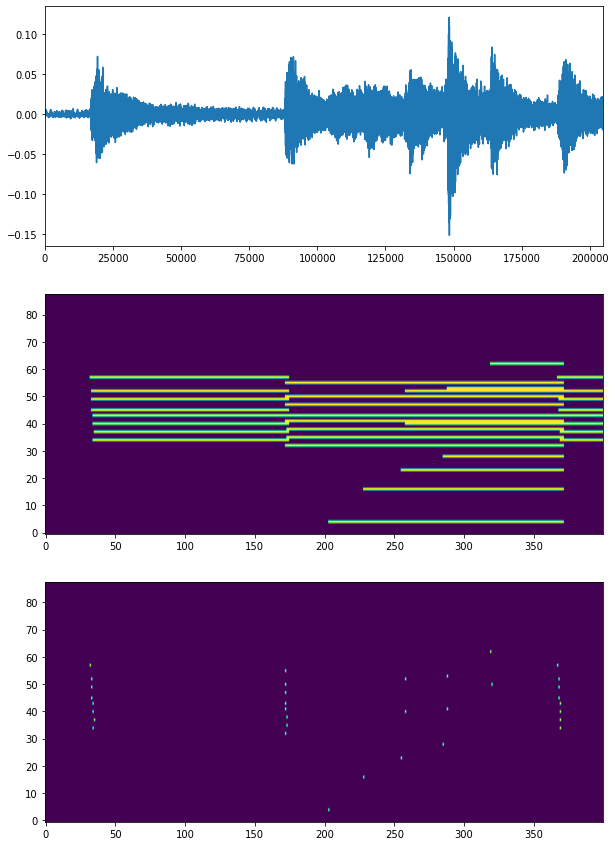

In [14]:
plt.figure(figsize=(10,15))
plt.subplot(311)
plt.plot(data['audio'].numpy()[:400*HOP_SIZE])
plt.autoscale(enable=True, axis='x', tight=True)
plt.subplot(312)
plt.imshow(data['frame'].numpy()[:400].T, aspect='auto', origin='lower')
plt.subplot(313)
plt.imshow(data['onset'].numpy()[:400].T, aspect='auto', origin='lower')

# Train 1k (Baseline)

In [ ]:
! python train.py -i=1000 -vi=500 --save_midi

Loading 1 group(s) of MAESTRO_small at data
Loading group train: 100%|████████████████████| 100/100 [00:25<00:00,  3.87it/s]
Loading 1 group(s) of MAESTRO_small at data
 50%|███████████▍           | 499/1000 [01:01<00:59,  8.40it/s, loss: 1.281e-01]/usr/local/lib/python3.6/dist-packages/mir_eval/transcription.py:167: UserWarning: Estimated notes are empty.
  warnings.warn("Estimated notes are empty.")

metric/loss/frame_loss      : 0.0771
metric/loss/onset_loss      : 0.0928
metric/frame/frame_f1       : 0.6097
metric/frame/onset_f1       : 0.5390
metric/note/f1              : 0.6121
metric/note-with-offsets/f1 : 0.2388
100%|██████████████████████▉| 999/1000 [02:04<00:00,  7.63it/s, loss: 1.646e-01]
metric/loss/frame_loss      : 0.0692
metric/loss/onset_loss      : 0.0889
metric/frame/frame_f1       : 0.6517
metric/frame/onset_f1       : 0.5963
metric/note/f1              : 0.6981
metric/note-with-offsets/f1 : 0.3033
100%|██████████████████████| 1000/1000 [02:04<00:00,  8.01it/s, loss:

You will have your model checkpoints & decoded samples in runs/exp_{datetime} folder

# Question 4: Discuss and analyze the results

In [1]:
%cd ..

/root/home/project/gct634-ai613-2021/hw3


In [4]:
import numpy as np
import torch
import pretty_midi
import soundfile
from dataset import MAESTRO_small
from constants import HOP_SIZE, MAX_MIDI, MIN_MIDI, SAMPLE_RATE
import matplotlib.pyplot as plt

In [5]:
test_dataset = MAESTRO_small(groups=['test'], hop_size=HOP_SIZE, random_sample=False)

Loading group test:   2%|▏         | 1/50 [00:00<00:07,  6.32it/s]

Loading 1 group(s) of MAESTRO_small at data


Loading group test: 100%|██████████| 50/50 [00:10<00:00,  4.75it/s]


In [28]:
original_data = test_dataset[0]
print(original_data['path'])
print(original_data['path'].split('/')[2])

data/2004/MIDI-Unprocessed_SMF_17_R1_2004_03-06_ORIG_MID--AUDIO_20_R2_2004_12_Track12_wav--1.flac
MIDI-Unprocessed_SMF_17_R1_2004_03-06_ORIG_MID--AUDIO_20_R2_2004_12_Track12_wav--1.flac


In [79]:
# baseline
midi_path = 'runs/ONF20000/'+(test_dataset.files('test')[0][1]).split('/')[2]
# rnn
#midi_path = 'runs/RNN10000/'+(test_dataset.files('test')[0][1]).split('/')[2]
# crnn
#midi_path = 'runs/CRNN10000/'+(test_dataset.files('test')[0][1]).split('/')[2]
# ONF
#midi_path = 'runs/Baseline10000/'+(test_dataset.files('test')[0][1]).split('/')[2]
audio_path = midi_path.split('.')[0]+'.wav'
print(midi_path)
print(audio_path)

runs/ONF20000/MIDI-Unprocessed_SMF_17_R1_2004_03-06_ORIG_MID--AUDIO_20_R2_2004_12_Track12_wav--1.midi
runs/ONF20000/MIDI-Unprocessed_SMF_17_R1_2004_03-06_ORIG_MID--AUDIO_20_R2_2004_12_Track12_wav--1.wav


In [80]:
audio, sr = soundfile.read(audio_path, dtype='int16')
assert sr == SAMPLE_RATE
frames_per_sec = sr / HOP_SIZE

audio = torch.ShortTensor(audio)
audio_length = len(audio)

mel_length = audio_length // HOP_SIZE + 1

midi = pretty_midi.PrettyMIDI(midi_path)
midi_length_sec = midi.get_end_time()
frame_length = min(int(midi_length_sec * frames_per_sec), mel_length)

audio = audio[:frame_length * HOP_SIZE]
frame = midi.get_piano_roll(fs=frames_per_sec)
onset = np.zeros_like(frame)
for inst in midi.instruments:
    for note in inst.notes:
        onset[note.pitch, int(note.start * frames_per_sec)] = 1

# to shape (time, pitch (88))
frame = torch.from_numpy(frame[MIN_MIDI:MAX_MIDI + 1].T)
onset = torch.from_numpy(onset[MIN_MIDI:MAX_MIDI + 1].T)
modelpass_data = dict(path=audio_path, audio=audio, frame=frame, onset=onset)

audio = modelpass_data['audio']
frames = (modelpass_data['frame'] >= 1)
onsets = (modelpass_data['onset'] >= 1)

sample_length=16000 * 5
random_sample=True
frame_len = frames.shape[0]
random = np.random.RandomState(42)
if sample_length is not None:
    n_steps = sample_length // HOP_SIZE

    if random_sample:
        step_begin = random.randint(frame_len - n_steps)
        step_end = step_begin + n_steps
    else:
        step_begin = 0
        step_end = n_steps

    begin = step_begin * HOP_SIZE
    end = begin + sample_length

    audio_seg = audio[begin:end]
    frame_seg = frames[step_begin:step_end]
    onset_seg = onsets[step_begin:step_end]

    result = dict(path=modelpass_data['path'])
    result['audio'] = audio_seg.float().div_(32768.0)
    result['frame'] = frame_seg.float()
    result['onset'] = onset_seg.float()
else:
    result = dict(path=modelpass_data['path'])
    result['audio'] = audio.float().div_(32768.0)
    result['frame'] = frames.float()
    result['onset'] = onsets.float()
print(modelpass_data)

{'path': 'runs/ONF20000/MIDI-Unprocessed_SMF_17_R1_2004_03-06_ORIG_MID--AUDIO_20_R2_2004_12_Track12_wav--1.wav', 'audio': tensor([   0,    0,    0,  ..., -259, -458, -594], dtype=torch.int16), 'frame': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], dtype=torch.float64), 'onset': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], dtype=torch.float64)}


Text(0.5, 1.0, 'Comparison (Groud Truth and ONF10000)')

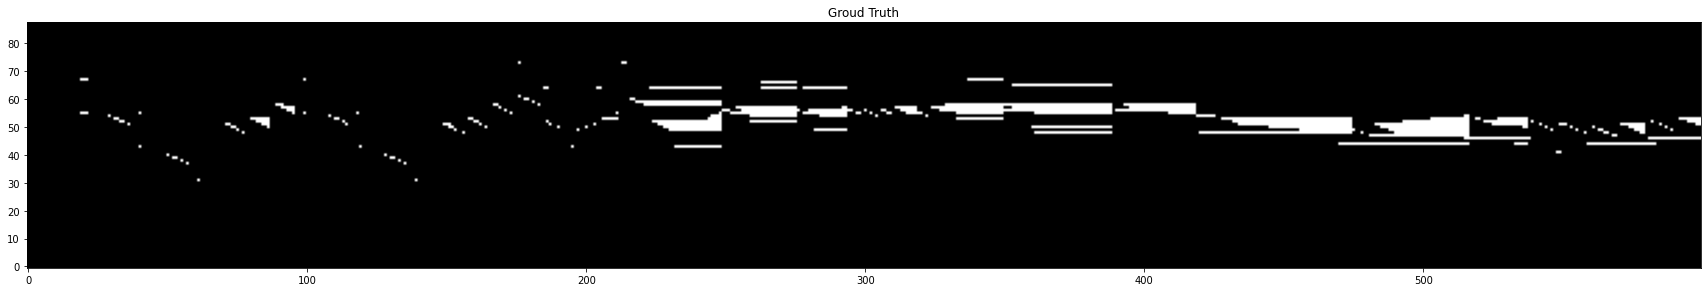

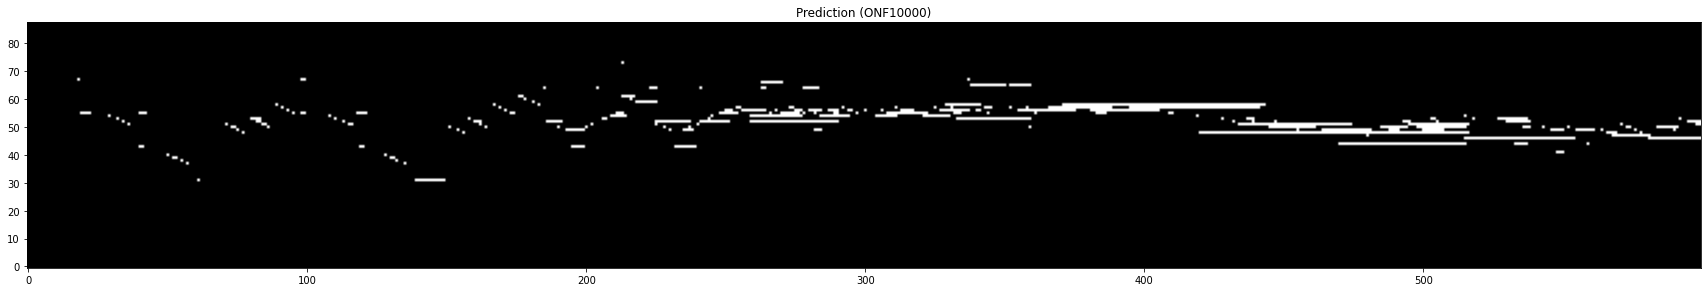

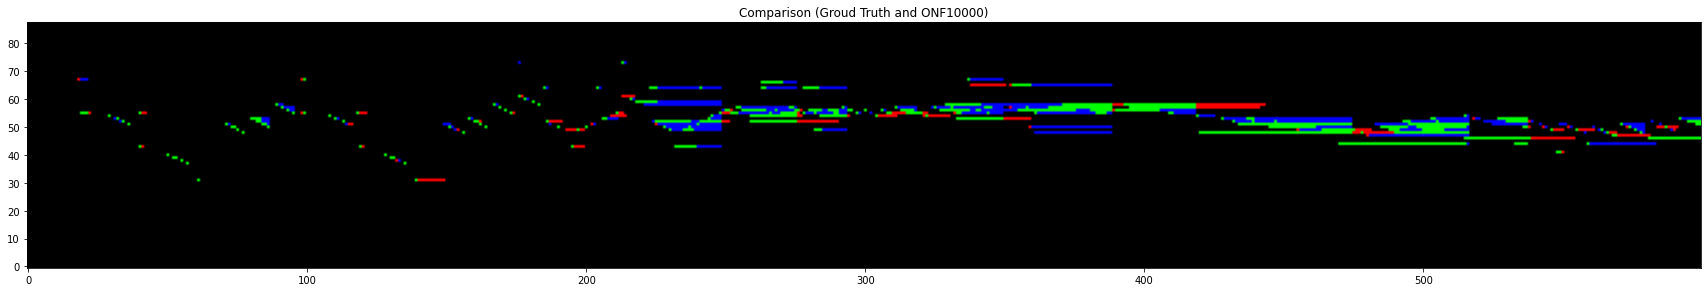

In [81]:
plt.figure(figsize=(30,30))
plt.imshow(original_data['frame'].numpy()[1:601].T, cmap='gray') 
plt.gca().invert_yaxis()
plt.title('Groud Truth')

plt.figure(figsize=(30,30))
plt.imshow(modelpass_data['frame'].numpy()[0:600].T, cmap='gray')  
plt.gca().invert_yaxis()
plt.title('Prediction (ONF10000)')

'''
    True Positive: 정답이 Yes인
    False Positive: 정답이 No인 문제를 Yes라고 한 경우
    False Negative: 정답이 Yes인 문제를 No라고 한 경우
'''

temp = np.zeros((3, original_data['frame'].numpy()[1:601].T.shape[0], original_data['frame'].numpy()[1:601].T.shape[1]))
# True Positive (Green)
idx1 = (original_data['frame'].numpy()[1:601].T*127==modelpass_data['frame'].numpy()[0:600].T)
idx2 = (original_data['frame'].numpy()[1:601].T>0) 
idx_truepositive = idx1 & idx2
temp[1][idx_truepositive]=1

# False Positive (Red)
idx1 = (original_data['frame'].numpy()[1:601].T*127!=modelpass_data['frame'].numpy()[0:600].T)
idx2 = (modelpass_data['frame'].numpy()[0:600].T>0) 
idx_falsepositive = idx1 & idx2
temp[0][idx_falsepositive]=1

# False Negative (Blue)
idx1 = (original_data['frame'].numpy()[1:601].T*127!=modelpass_data['frame'].numpy()[0:600].T)
idx2 = (modelpass_data['frame'].numpy()[0:600].T==0) 
idx_falsenegative = idx1 & idx2
temp[2][idx_falsenegative]=1

plt.figure(figsize=(30,30))
plt.imshow(np.moveaxis(temp, 0, -1))
plt.gca().invert_yaxis()
plt.title('Comparison (Groud Truth and ONF10000)')

Text(0.5, 1.0, 'Comparison (Groud Truth and ONF10000)')

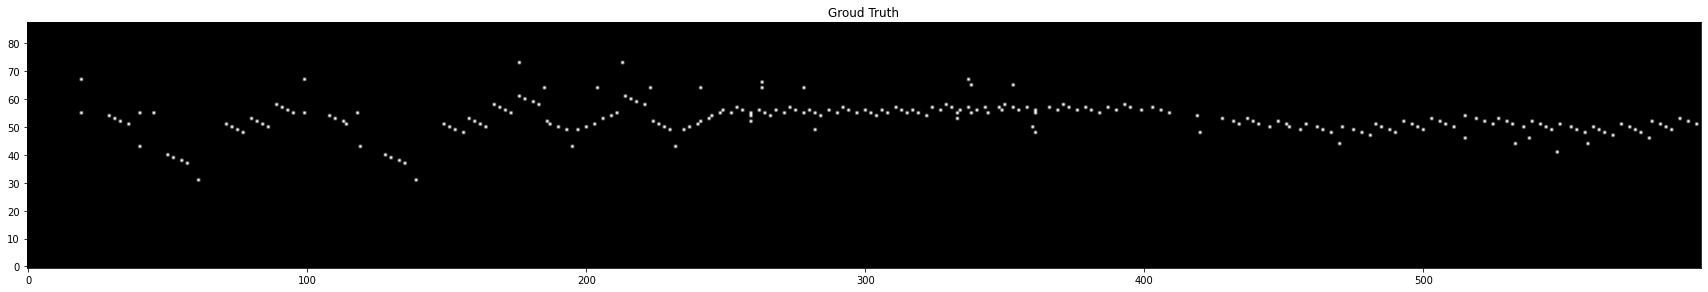

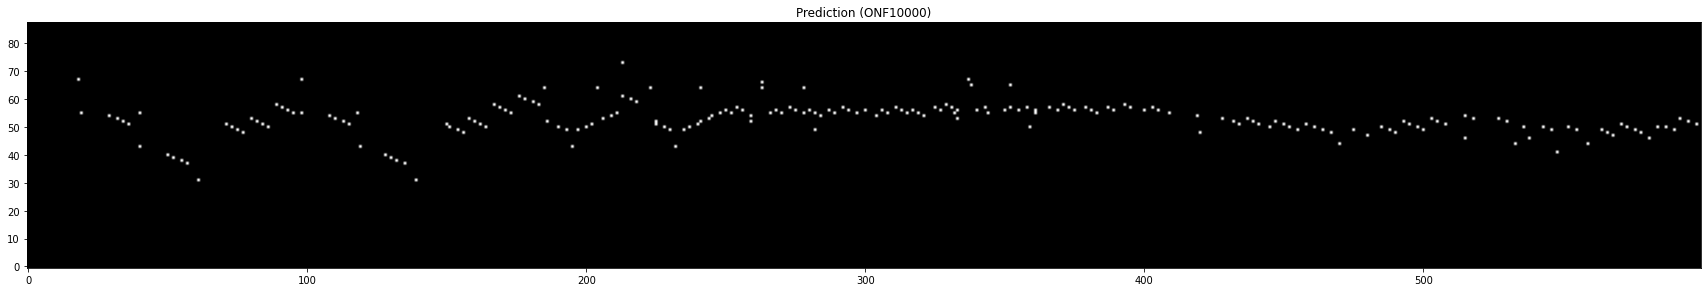

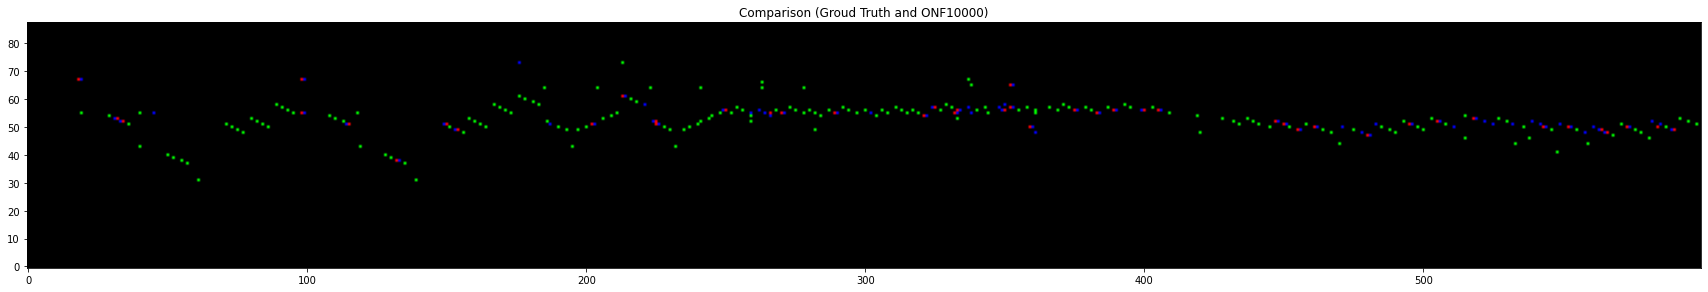

In [82]:
plt.figure(figsize=(30,30))
plt.imshow(original_data['onset'].numpy()[1:601].T, cmap='gray') 
plt.gca().invert_yaxis()
plt.title('Groud Truth')

plt.figure(figsize=(30,30))
plt.imshow(modelpass_data['onset'].numpy()[0:600].T, cmap='gray')  
plt.gca().invert_yaxis()
plt.title('Prediction (ONF10000)')

'''
    True Positive: 정답이 Yes인
    False Positive: 정답이 No인 문제를 Yes라고 한 경우
    False Negative: 정답이 Yes인 문제를 No라고 한 경우
'''
temp = np.zeros((3, original_data['onset'].numpy()[1:601].T.shape[0], original_data['onset'].numpy()[1:601].T.shape[1]))
# True Positive
idx1 = (original_data['onset'].numpy()[1:601].T==modelpass_data['onset'].numpy()[0:600].T)
idx2 = (original_data['onset'].numpy()[1:601].T>0) 
idx_truepositive = idx1 & idx2
temp[1][idx_truepositive]=1

# False Positive
idx1 = (original_data['onset'].numpy()[1:601].T!=modelpass_data['onset'].numpy()[0:600].T)
idx2 = (modelpass_data['onset'].numpy()[0:600].T>0) 
idx_falsepositive = idx1 & idx2
temp[0][idx_falsepositive]=1
# False Negative
idx1 = (original_data['onset'].numpy()[1:601].T!=modelpass_data['onset'].numpy()[0:600].T)
idx2 = (modelpass_data['onset'].numpy()[0:600].T==0) 
idx_falsenegative = idx1 & idx2
temp[2][idx_falsenegative]=1

plt.figure(figsize=(30,30))
plt.imshow(np.moveaxis(temp, 0, -1))
plt.gca().invert_yaxis()
plt.title('Comparison (Groud Truth and ONF10000)')